In [810]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator  # interval in axis of charts
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import seaborn as sns

import warnings

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')

In [811]:
import os

for dirname, _, filenames in os.walk('input/'):
    for filename in filenames:
        print(f'./{dirname}/{filename}')

./input/real_estate_price_prediction_moscow/sample_submission.csv
./input/real_estate_price_prediction_moscow/test.csv
./input/real_estate_price_prediction_moscow/train.csv


In [812]:
TRAIN_DATASET_PATH = './input/real_estate_price_prediction_moscow/train.csv'
TEST_DATASET_PATH = './input/real_estate_price_prediction_moscow/test.csv'

In [813]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


In [814]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [815]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B


In [816]:
print(f'Strings in train: {train_df.shape[0]}')
print(f'Strings in test: {test_df.shape[0]}')

Strings in train: 10000
Strings in test: 5000


In [817]:
# check the number of columns (train have col=Price --> target)
train_df.shape[1] - test_df.shape[1] == 1

True

In [818]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [819]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### 1. EDA

In [820]:
# error corection in titles and delete id исправление ошибок
train_df.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)        
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850


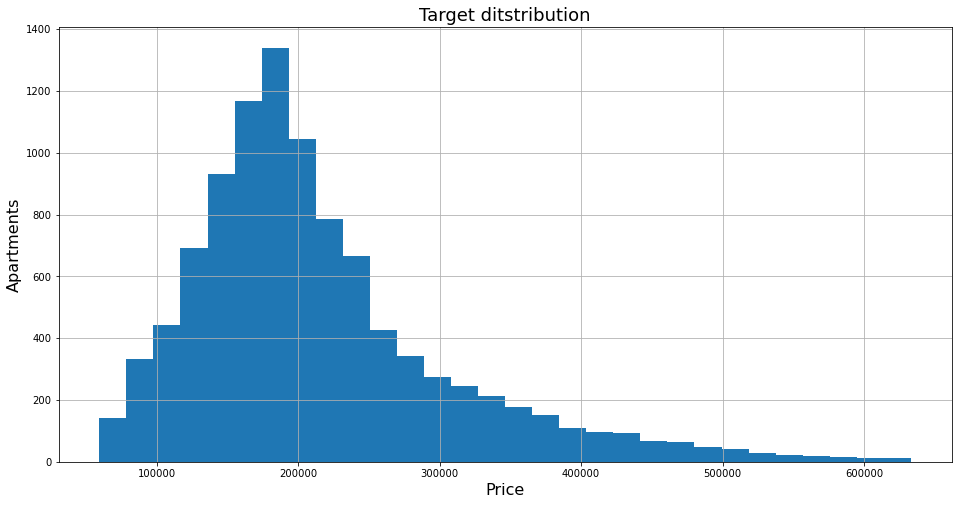

In [821]:
plt.figure(figsize=(16, 8))
train_df['Price'].hist(bins=30)
plt.xlabel('Price', fontsize=16)
plt.ylabel('Apartments', fontsize=16)
plt.title('Target ditstribution', fontsize=18)
plt.show()

#### ~ Quantitative variables

In [822]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### ~ Nominative variables

In [824]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

### 2. Processing of emissions

#### round values

In [ ]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']]

#### DistrictId

In [ ]:
train_df.loc[train_df['DistrictId'.isna()]
train_df.loc[train_df['DistrictId'.isna()] = train_df.loc[train_df['DistrictId'.isna()].merge()

#### Rooms

In [828]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [829]:
# create Rooms_outlier
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.groupby(['Rooms_outlier'])['Rooms'].value_counts()

Rooms_outlier  Rooms
0              2.0      3880
               1.0      3705
               3.0      2235
               4.0       150
               5.0        18
1              0.0         8
               10.0        2
               6.0         1
               19.0        1
Name: Rooms, dtype: int64

In [830]:
# replacement 0 by 1 room
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

# replacement rooms >= 6
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

train_df['Rooms'] = train_df['Rooms'].astype(int)

#### HouseFloor

In [831]:
# if HouseFloor == 0 --> HouseFloor = Floor
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df[train_df['HouseFloor'] == 0]['Floor']
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

#### Floor

In [832]:
# if Floor > HouseFloor --> Floor = HouseFloor
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] \
= train_df[train_df['Floor'] > train_df['HouseFloor']]['HouseFloor']

#### HouseYear

In [833]:
train_df.loc[(train_df['HouseYear'] < 1900), 'HouseYear'] = int(train_df['HouseYear'].median())
train_df.loc[(train_df['HouseYear'] > 2020), 'HouseYear'] = 2020

#### Square

In [889]:
# Replace Square > 250 per median Square
train_df.loc[train_df['Square'] > 250, 'Square'] = train_df[train_df['Square'] <= 250]['Square'].median()





















# The smallest apartments in Moscow --> 8.3 m^2 (to use 8)
train_df.loc[train_df['Square'] < 8, 'Square'] = train_df[train_df['Square'].isna()]['KitchenSquare'] + train_df[train_df['Square'].isna()]['LifeSquare'] + 3

train_df.loc[train_df['Square'].isna(), 'Square'] = train_df[train_df['Square'].isna()]['KitchenSquare'] + train_df[train_df['Square'].isna()]['LifeSquare'] + 3

train_df['Square'] = train_df['Square'].round().astype(int)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,40,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,30,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


#### KitchenSquare

In [835]:
train_df[train_df['KitchenSquare'] > 200] = train_df['KitchenSquare'].median()
train_df['KitchenSquare'] = train_df['KitchenSquare'].round(0).astype(int)

#### LifeSquare

In [836]:
# find LifeSquare > Square - KitchenSquare
train_df.loc[train_df['LifeSquare'] > 220, 'LifeSquare'] = train_df[train_df['LifeSquare'] <= 220]['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] > (train_df['Square'] - train_df['KitchenSquare'] - 3), 'LifeSquare'] \
= train_df['Square'] - train_df['KitchenSquare'] - 3


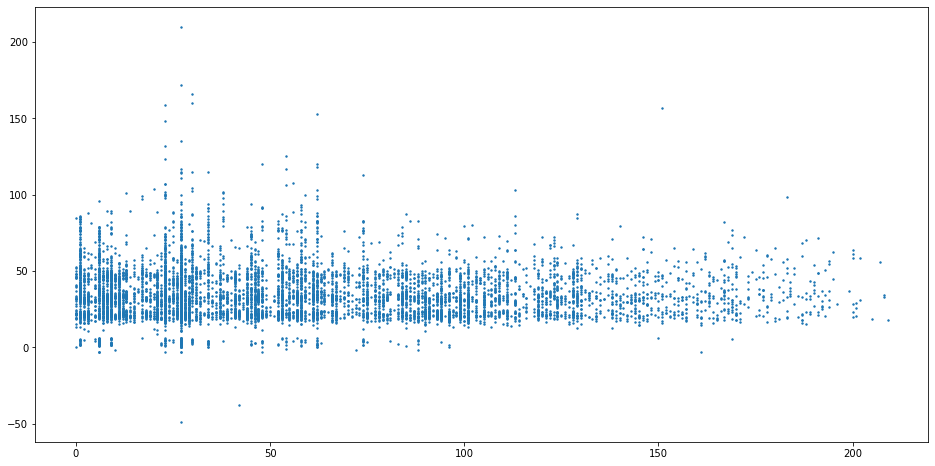

In [837]:
plt.figure(figsize=(16, 8))
plt.scatter(train_df['DistrictId'], train_df['LifeSquare'], s=2, label='LifeSquare')

In [838]:
#chart_scatter_standart('DistrictId', ['Square', 'KitchenSquare', 'LifeSquare'], 'output data --> LifeSquare', 20, 20)

# plt.figure(figsize=(16, 8))

# for val in ['Square', 'KitchenSquare', 'LifeSquare']:
#     plt.scatter(train_df['DistrictId'], train_df[val], s=2, label=val)

# plt.tick_params(axis='both',which='major',labelsize=14, color='red')
# ax=plt.gca()
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
# plt.title('Square, KitchenSquare, LifeSquare', fontsize=18)
# plt.grid(color='lavender')
# plt.xlabel('DistrictId')
# plt.ylabel('Square, KitchenSquare, LifeSquare')
# plt.legend()
# plt.show()

In [839]:
train_df[train_df['DistrictId'] < 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price,Rooms_outlier


### 3. NaN

In [840]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Rooms_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5203.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8380.475400,50.387700,1.888600,56.136300,34.920252,5.876100,7.944200,12.85320,1984.474500,0.120050,24.685000,5351.567200,8.040300,1142.563137,1.320100,4.231900,214117.470895,0.002400
std,4859.649787,43.590884,0.813423,19.025476,16.697709,5.174014,5.227276,6.53539,33.498925,0.145198,17.533058,4007.234666,23.831653,1021.638926,1.494276,4.806187,92909.283712,0.091625
min,0.000000,0.000000,1.000000,6.000000,-49.000000,0.000000,1.000000,1.00000,6.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,4166.750000,20.000000,1.000000,42.000000,22.662203,1.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000
50%,8392.500000,35.000000,2.000000,53.000000,32.302283,6.000000,7.000000,14.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000
75%,12590.250000,75.000000,2.000000,66.000000,44.310188,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000
max,16798.000000,209.000000,6.000000,213.000000,210.000000,123.000000,42.000000,117.00000,2020.000000,6.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,6.000000


#### LifeSquare

Find ratio lifeSquare / Square; (by districts) \
Ratio will use for replace NaN LifeSquare

In [841]:
# Select rows with normal 'LifeSquare', where LifeSquare <= Square and 'LifeSquare' != NaN
#df_ls = train_df[~(train_df['LifeSquare'].isna())]
#df_ls.shape

In [842]:
# Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
district_sq_mean = df_ls.groupby('DistrictId').mean()['Square']
district_lsq_mean = df_ls.groupby('DistrictId').mean()['LifeSquare']

k_mean_life_square = pd.DataFrame(district_lsq_mean / district_sq_mean, columns=['K_LS_S']).reset_index()
k_mean_life_square

,DistrictId,K_LS_S
0,0,0.594136
1,1,0.751875
2,2,0.595269
3,3,0.608564
4,4,0.651541
...,...,...
200,202,0.657164
201,205,0.434036
202,207,0.724286
203,208,0.618474


In [843]:
train_df = train_df.merge(k_mean_life_square, on=['DistrictId'])

In [844]:
train_df.loc[(train_df['LifeSquare'].isna()), 'LifeSquare'] = \
train_df.loc[(train_df['LifeSquare'].isna()), 'Square'] * train_df.loc[(train_df['LifeSquare'].isna()), 'K_LS_S']
train_df['LifeSquare'] = train_df['LifeSquare'].round().astype(int)

#### Healthcare_1

In [845]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [846]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price,Rooms_outlier,K_LS_S
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8380.475400,50.387700,1.888600,56.136300,36.248800,5.876100,7.944200,12.85320,1984.474500,0.120050,24.685000,5351.567200,8.040300,1026.205600,1.320100,4.231900,214117.470895,0.002400,0.644484
std,4859.649787,43.590884,0.813423,19.025476,16.267998,5.174014,5.227276,6.53539,33.498925,0.145198,17.533058,4007.234666,23.831653,746.791444,1.494276,4.806187,92909.283712,0.091625,0.053285
min,0.000000,0.000000,1.000000,6.000000,-49.000000,0.000000,1.000000,1.00000,6.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.434036
25%,4166.750000,20.000000,1.000000,42.000000,24.000000,1.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,0.000000,0.607975
50%,8392.500000,35.000000,2.000000,53.000000,33.000000,6.000000,7.000000,14.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.633082
75%,12590.250000,75.000000,2.000000,66.000000,46.000000,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,0.000000,0.670299
max,16798.000000,209.000000,6.000000,213.000000,210.000000,123.000000,42.000000,117.00000,2020.000000,6.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,6.000000,0.784180


In [847]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Healthcare_2     0
Shops_1          0
Shops_2          0
Price            0
Rooms_outlier    0
K_LS_S           0
dtype: int64

In [848]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

#### ~ class DataPreprocessing

In [849]:
class DataPreprocessing:
    """Preparation of initial data"""
    
    def __init__(self):
        """Class parameters"""
        self.medians = None
        self.binary_to_numbers = None
        
    def fit(self, X):
        """saving statistics"""
        # Calculation of medians
        
        self.medians = X.median()
        
    def transform(self, X):
        """data transformation"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X[train_df['HouseFloor'] == 0]['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X[X['Floor'] > X['HouseFloor']]['HouseFloor']
        
        #HouseYear
        X.loc[(X['HouseYear'] < 1900), 'HouseYear'] = int(X['HouseYear'].median())
        X.loc[(X['HouseYear'] > 2020), 'HouseYear'] = 2020

        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].median()
        
        # Healthcare_2
        X.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)   
            
        # Square
        ## Exclude with help chart emissions > 250
        X.loc[(X['Square'] > 250) | (X['Square'] == 0), 'Square'] = X['Square'].median()

        ## The smallest apartments in Moscow --> 8.3 m^2 (to use 8)
        X.loc[X['Square'] < 8, 'Square'] = 8
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[(X['KitchenSquare'].isna()) | (X['KitchenSquare'] > 200), 'KitchenSquare'] = X['KitchenSquare'].median()
        
        #LifeSquare
        X.loc[(X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 3)) | \
              (X['LifeSquare'].isna()), 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3
        
        ## Create ratio lifeSquare / square (for replace NaN LifeSquare) (by DistrictId)
        district_lsq_mean = X.groupby('DistrictId').mean()['LifeSquare']
        district_sq_mean = X.groupby('DistrictId').mean()['Square']
    
        k_mean_life_square = pd.DataFrame(district_lsq_mean / district_sq_mean, columns=['K_LS_S']).reset_index()
    
        X = X.merge(k_mean_life_square, on=['DistrictId'], how='left')

        X.loc[(X['LifeSquare'].isna()), 'LifeSquare'] = \
        X.loc[(X['LifeSquare'].isna()), 'Square'] * X.loc[(X['LifeSquare'].isna()), 'K_LS_S']
        
        # round features
        X[['Square', 'KitchenSquare', 'LifeSquare']] = X[['Square', 'KitchenSquare', 'LifeSquare']].round()
        
        X.fillna(self.medians, inplace=True)
        
        # type int
        X[['Rooms', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']]\
        = X[['Rooms', 'HouseFloor', 'Square', 'LifeSquare', 'KitchenSquare']].astype(int)
        
        return X

In [850]:
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']]

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,A
2,B,B,B
3,B,B,A
4,B,B,B
...,...,...,...
9995,B,B,B
9996,B,B,B
9997,B,B,B
9998,B,B,B


### 4. Building new features 

#### MeanSquareRooms

In [851]:
mean_square_rooms = train_df.groupby('DistrictId', as_index=False)[['Rooms', 'LifeSquare']].sum()
mean_square_rooms['MeanSquareRooms'] = (mean_square_rooms['LifeSquare'] / mean_square_rooms['Rooms']).round().astype(int)
mean_square_rooms.drop(columns=['Rooms', 'LifeSquare'], inplace=True)
train_df = train_df.merge(mean_square_rooms, on=['DistrictId'], how='left')
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,K_LS_S,MeanSquareRooms
0,11809,27,3,115,73,10,4,10,2014,0.075424,...,11,3097,0,0,0,B,305018.871089,0,0.632682,21
1,4717,27,1,44,28,0,2,2,1977,0.072158,...,2,629,1,0,0,A,135466.559958,0,0.632682,21
2,7757,27,2,59,45,11,12,12,1977,0.011654,...,4,915,0,0,0,B,138396.984612,0,0.632682,21
3,6846,27,1,52,33,6,13,17,1977,0.072158,...,2,629,1,0,0,A,155463.092033,0,0.632682,21
4,13726,27,1,48,23,1,1,1,1977,0.017647,...,2,469,0,0,0,B,130190.643579,0,0.632682,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9788,16,3,65,46,6,9,9,1978,0.037178,...,52,11217,1,1,7,B,254692.419760,0,0.685038,14
9996,15193,195,3,76,45,9,5,7,1917,0.015017,...,17,3079,59,0,8,B,486057.129888,0,0.623545,13
9997,4282,195,5,96,62,7,7,7,1940,0.015017,...,17,3079,59,0,8,B,479525.147323,0,0.623545,13
9998,11911,209,1,34,18,5,5,5,1965,0.040243,...,25,3478,11,3,1,B,140048.802277,0,0.532386,18


#### Dummies

In [852]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

In [853]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
.rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})

In [854]:
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,513
4,9,294


In [855]:
train_df = pd.merge(train_df, district_size, on='DistrictId', how='left')

In [856]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,K_LS_S,MeanSquareRooms,DistrictSize
0,11809,27,3,115,73,10,4,10,2014,0.075424,...,3097,0,0,0,1.0,305018.871089,0,0.632682,21,851
1,4717,27,1,44,28,0,2,2,1977,0.072158,...,629,1,0,0,0.0,135466.559958,0,0.632682,21,851
2,7757,27,2,59,45,11,12,12,1977,0.011654,...,915,0,0,0,1.0,138396.984612,0,0.632682,21,851
3,6846,27,1,52,33,6,13,17,1977,0.072158,...,629,1,0,0,0.0,155463.092033,0,0.632682,21,851
4,13726,27,1,48,23,1,1,1,1977,0.017647,...,469,0,0,0,1.0,130190.643579,0,0.632682,21,851


In [857]:
(train_df['DistrictSize'] > 100).value_counts()

True     5070
False    4930
Name: DistrictSize, dtype: int64

In [858]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict

In [859]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False)['Price'].median()\
.rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head(10)

,DistrictId,Rooms,MedPriceByDistrict
0,0,1,142799.434052
1,0,2,176210.812334
2,0,3,300610.359425
3,1,1,146735.671740
4,1,2,202666.310126
5,1,3,244005.272380
6,1,4,277290.705058
7,2,1,174545.972737
8,2,2,215477.288974
9,2,3,323304.615000


In [860]:
med_price_by_district.shape

(668, 3)

In [861]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

#### MedPricebyFloorYear

In [862]:
def floor_to_cat(X):
    X['floor_cat'] = 0
    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat']  = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat']  = 4
    X.loc[X['Floor'] > 15, 'floor_cat']  = 5
    
    return X

In [863]:
def floor_to_cat_pandas(X):
    bins = [train_df['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['Floor_cat'].fillna(-1, inplace=True)
    
    return X

In [864]:
def year_to_cat(X):
    X['year_cat'] = 0
    
    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6
    
    return X

In [865]:
def year_to_cat_pandas(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    
    return X

In [866]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, include_lowest=True)

0         (3.0, 5.0]
1       (0.999, 3.0]
2        (9.0, 15.0]
3        (9.0, 15.0]
4       (0.999, 3.0]
            ...     
9995      (5.0, 9.0]
9996      (3.0, 5.0]
9997      (5.0, 9.0]
9998      (3.0, 5.0]
9999      (3.0, 5.0]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[float64, right]): [(0.999, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 42.0]]

In [867]:
bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, include_lowest=True, labels=False)

0       1
1       0
2       3
3       3
4       0
       ..
9995    2
9996    1
9997    2
9998    1
9999    1
Name: Floor, Length: 10000, dtype: int64

In [868]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,K_LS_S,MeanSquareRooms,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3,115,73,10,4,10,2014,0.075424,...,1.0,305018.871089,0,0.632682,21,851,1,213530.788443,6,2
1,4717,27,1,44,28,0,2,2,1977,0.072158,...,0.0,135466.559958,0,0.632682,21,851,1,118349.682906,3,1
2,7757,27,2,59,45,11,12,12,1977,0.011654,...,1.0,138396.984612,0,0.632682,21,851,1,165683.084779,3,4
3,6846,27,1,52,33,6,13,17,1977,0.072158,...,0.0,155463.092033,0,0.632682,21,851,1,118349.682906,3,4
4,13726,27,1,48,23,1,1,1,1977,0.017647,...,1.0,130190.643579,0,0.632682,21,851,1,118349.682906,3,1


In [869]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'}).\
rename(columns={'Price': 'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,324303.812481
2,1,3,392227.551759
3,1,4,274992.472366
4,2,1,467230.539057


In [870]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')

In [871]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,K_LS_S,MeanSquareRooms,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3,115,73,10,4,10,2014,0.075424,...,305018.871089,0,0.632682,21,851,1,213530.788443,6,2,161744.506404
1,4717,27,1,44,28,0,2,2,1977,0.072158,...,135466.559958,0,0.632682,21,851,1,118349.682906,3,1,178894.793693
2,7757,27,2,59,45,11,12,12,1977,0.011654,...,138396.984612,0,0.632682,21,851,1,165683.084779,3,4,184303.152266
3,6846,27,1,52,33,6,13,17,1977,0.072158,...,155463.092033,0,0.632682,21,851,1,118349.682906,3,4,184303.152266
4,13726,27,1,48,23,1,1,1,1977,0.017647,...,130190.643579,0,0.632682,21,851,1,118349.682906,3,1,178894.793693


In [872]:
class FeatureGenerator:
    """Generation of new features"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.floor_min = None
        self.floor_max = None
        self.house_year_min = None
        self.house_year_max = None
        self.district_size = None
        self.mean_square_rooms = None
        
    
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 1, 'B': 2}

        # DistrictId
        self.district_size = X['DistrictId'].value_counts()\
        .reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## Floor, HouseYear
        if y is not None:
            self.floor_min = df['Floor'].min()
            self.floor_max = df['Floor'].max()
            self.house_year_min = df['HouseYear'].min()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price': 'median'})\
            .rename(columns={'Price': 'MedPriceByFloorYear'})
            
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) # A -> 0, B -> 1
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on=['DistrictId'], how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # MeanSquareRooms
        self.mean_square_rooms = X.groupby(['DistrictId'], as_index=False)[['Rooms', 'LifeSquare']].sum()
        
        self.mean_square_rooms['MeanSquareRooms'] = \
        (self.mean_square_rooms['LifeSquare'] / self.mean_square_rooms['Rooms']).round().astype(int)
        self.mean_square_rooms.drop(columns=['Rooms', 'LifeSquare'], inplace=True)
        X = X.merge(self.mean_square_rooms, on=['DistrictId'], how='left')
        
        
        # More Categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        #target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
            
        return X
    
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], include_lowest=True, bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X
    
    
    def year_to_cat(self, X):
        bins= [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X
    
    

### 5. Feature selection

In [873]:
train_df.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'K_LS_S',
 'MeanSquareRooms',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [874]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Healthcare_2',
                 'Social_1', 'Social_2', 'Social_3', 'Shops_2', 'Shops_1', 'Ecology_1', 'Ecology_2', 'Ecology_3']

new_feature_names = ['MedPriceByDistrict', 'MedPriceByFloorYear', 'MeanSquareRooms', 'DistrictSize', 'IsDistrictLarge', 'K_LS_S']
#'Rooms_outlier'

target_name = 'Price'

### 6. Splitting into train / test

In [875]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [876]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, shuffle=True, random_state=21)

In [877]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((9000, 21), (1000, 21), (5000, 21))

In [878]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [879]:
X_train.shape, X_valid.shape, test_df.shape

((9000, 29), (1000, 29), (5000, 29))

In [880]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [881]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Building a model

#### Learning

In [882]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.967
Test R2:	0.727


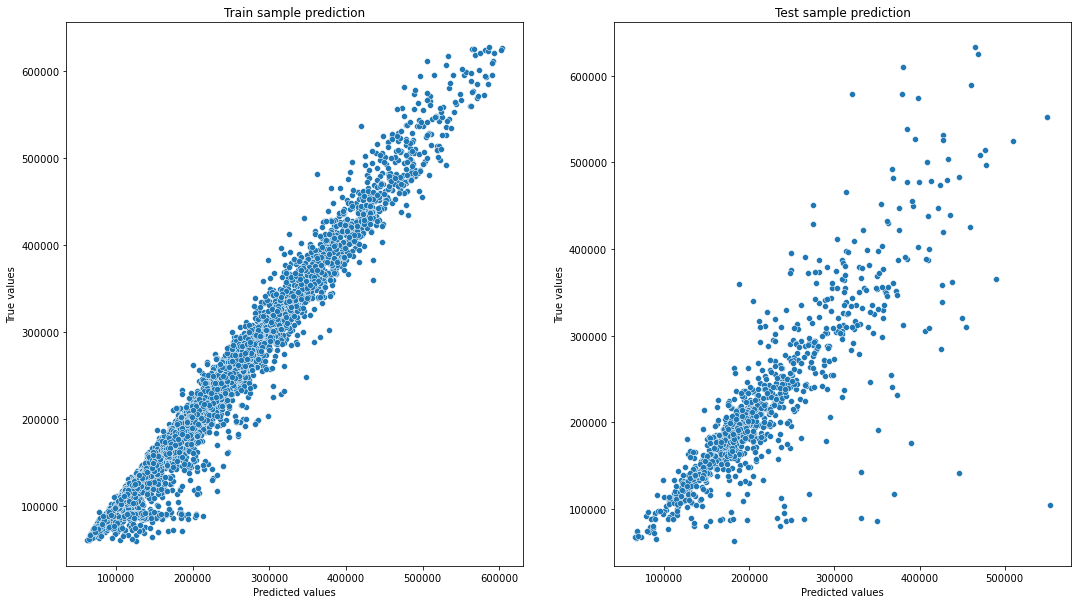

In [883]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Cross validation

In [884]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72366848, 0.76803343, 0.75678881])

In [885]:
cv_score.mean()

0.7494969046393671

#### The importance of features

In [886]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
16,MedPriceByDistrict,0.619817
1,Square,0.113027
2,LifeSquare,0.030689
6,HouseYear,0.027373
5,HouseFloor,0.022824
3,KitchenSquare,0.022544
10,Social_3,0.022025
17,MedPriceByFloorYear,0.021940
4,Floor,0.020503
19,DistrictSize,0.018188


In [887]:
#### Other models
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

Train R2:	0.967
Test R2:	0.727


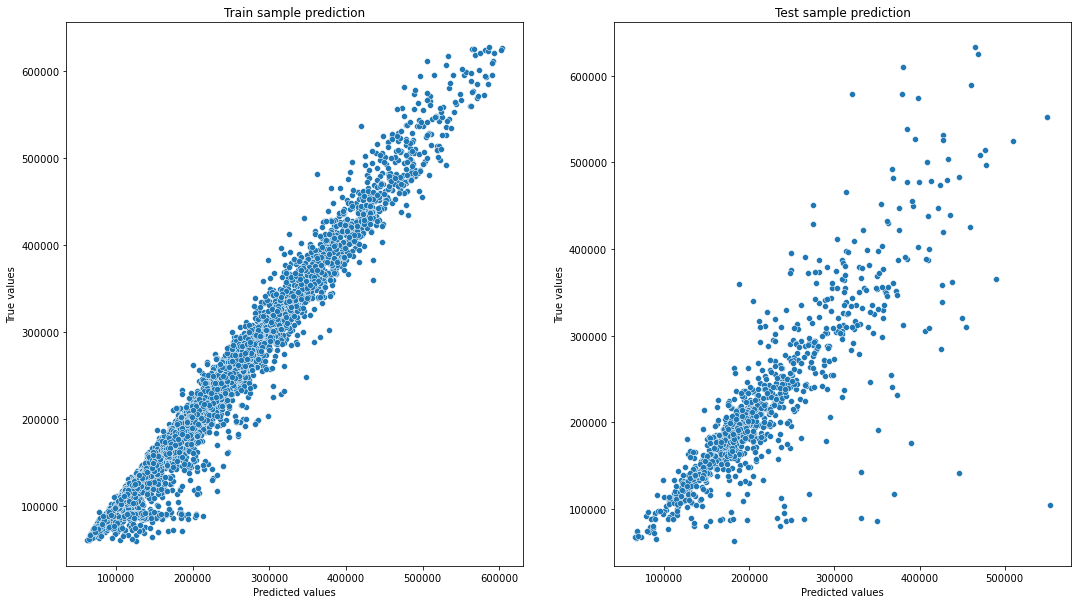

In [888]:
lr = LinearRegression()
gb = GradientBoostingRegressor()

stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)